## **1. Loading and normalizing CIFAR10**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
%%bash
ls data

cifar-10-batches-py
cifar-10-python.tar.gz


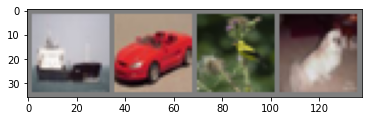

      ship        car       bird        dog


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## **2. Defining a Convolutional Neural Network**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## **3. Defining a Loss function and an optimizer**

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## **4. Training the Network**

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.852
[1,  4000] loss: 1.678
[1,  6000] loss: 1.587
[1,  8000] loss: 1.517
[1, 10000] loss: 1.468
[1, 12000] loss: 1.404
[2,  2000] loss: 1.358
[2,  4000] loss: 1.333
[2,  6000] loss: 1.316
[2,  8000] loss: 1.307
[2, 10000] loss: 1.278
[2, 12000] loss: 1.265
Finished Training


In [ ]:
# save the trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## **5. Testing the Network on the test data**

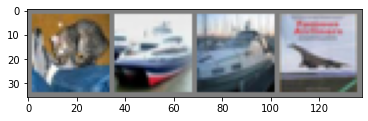

GroundTruth:    cat  ship  ship plane


In [ ]:
# display some images from the test set with their true labels
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# load back the saved model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)
# The outputs are energies for the 10 classes. The higher the energy for a class, 
# the more the network thinks that the image is of the particular class. 
# So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  ship   car  ship


In [ ]:
# Now, let's look at how the model performs on the whole test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
# What are the classes that performed well, and the classes that did not perform well ?

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 45 %
Accuracy of   car : 74 %
Accuracy of  bird : 53 %
Accuracy of   cat : 18 %
Accuracy of  deer : 35 %
Accuracy of   dog : 48 %
Accuracy of  frog : 82 %
Accuracy of horse : 51 %
Accuracy of  ship : 75 %
Accuracy of truck : 66 %


In [ ]:
# Training on GPU
# Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

# Let’s first define our device as the first visible cuda device if we have CUDA available:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
# Out: cuda:0 (but here we will have cpu)

# The rest of this section assumes that device is a CUDA device.
# Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

net.to(device)
# Remember that you will have to send the inputs and targets at every step to the GPU too:

inputs, labels = data[0].to(device), data[1].to(device)

cpu


## **6. Ray Tune for Automate Hyperparameters optimization**

In [ ]:
from functools import partial
import os
from torch.utils.data import random_split
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [ ]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# This is the training function

def train_cifar(config, checkpoint_dir=None, data_dir=None):

    '''The config parameter will receive the hyperparameters we would like to train with. 
    The checkpoint_dir parameter is used to restore checkpoints. 
    The data_dir specifies the directory where we load and store the data, 
    so multiple runs can share the same data source.'''
  
    # in the NN, the hidden sizes of the two linear layers are configurable
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    # the learning rate of the optimizer is made configurable too
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    # if the checkpoint_dir parameter is defined
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    # the training data is splitted into a training and validation subset. 
    # training is made on 80% of the data and the validation loss is calculated
    # on the remaining 20%
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    # the batch sizes with which we iterate through the training and test sets 
    # are configurable as well
    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    # the max number of epochs here is fixed, but we can make it configurable
    # as well
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # by using a device variable, we make sure that training 
            # also works when we have no GPUs available

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Here we first save a checkpoint and then report some metrics back to Ray Tune. 
        # Specifically, the validation loss and accuracy are sent back to Ray Tune. 
        # Ray Tune can then use these metrics to decide which hyperparameter configuration 
        # leads to the best results. 
        # These metrics can also be used to stop bad performing trials early 
        # in order to avoid wasting resources on those trials.
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

Commonly the performance of a machine learning model is tested on a hold-out test set with data that has not been used for training the model. We also wrap this in a function:

In [ ]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
# defining the main function

def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    # The tune.sample_from() function makes it possible to define your own sample methods to obtain hyperparameters.
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        # Here, the l1 and l2 parameters should be powers of 2 between 4 and 256, so either 4, 8, 16, 32, 64, 128, or 256.
        "lr": tune.loguniform(1e-4, 1e-1),
        # The lr (learning rate) should be uniformly sampled between 0.0001 and 0.1.
        "batch_size": tune.choice([2, 4, 8, 16])
        # The batch size is simply a choice between 2, 4, 8, and 16.
    }
    # At each trial, Ray Tune will randomly sample a combination of parameters from these search spaces. 
    # It will then train a number of models in parallel and find the best performing one among these.
    # We also use the `ASHAScheduler` which will terminate bad performing trials early.
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    # We wrap the train_cifar function with functools.partial to set the constant data_dir parameter. 
    # We can also tell Ray Tune what resources should be available for each trial
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)
    # You can specify the number of CPUs, which are then available e.g. to increase 
    # the num_workers of the PyTorch DataLoader instances. 
    # The selected number of GPUs are made visible to PyTorch in each trial. 
    # Trials do not have access to GPUs that haven’t been requested for them
    # so you don’t have to care about two trials using the same set of resources.

    # Here we can also specify fractional GPUs, so something like gpus_per_trial=0.5 is completely valid. 
    # The trials will then share GPUs among each other. 
    # You just have to make sure that the models still fit in the GPU memory.

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    # After training the models, we will find the best performing one 
    # and load the trained network from the checkpoint file. 

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    # We then obtain the test set accuracy and report everything by printing.

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

Files already downloaded and verified
Files already downloaded and verified


2020-12-16 13:09:43,255	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-16 13:09:46,550	WARNING experiment.py:274 -- No name detected on trainable. Using DEFAULT.
2020-12-16 13:09:46,564	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.
2020-12-16 13:09:46,607	INFO logger.py:201 -- pip install 'ray[tune]' to see TensorBoard files.
2020-12-16 13:09:46,614	WARNING logger.py:343 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.


== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects
Result logdir: /root/ray_results/DEFAULT_2020-12-16_13-09-46
Number of trials: 1/10 (1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-----------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |        lr |
|---------------------+----------+-------+--------------+------+------+-----------|
| DEFAULT_f878a_00000 | RUNNING  |       |            8 |  128 |   64 | 0.0191123 |
+---------------------+----------+-------+--------------+------+------+-----------+


(pid=693) Files already downloaded and verified
(pid=693) Files already downloaded and verified
(pid=693) [1,  2000] loss: 2.026
(pid=693) [1,  4000] loss: 0.957
Result for DEFAULT_f878a_00000:
  accuracy: 0.3042
  date: 2020-12-

2020-12-16 13:24:57,146	WARNING worker.py:1091 -- A worker died or was killed while executing task ffffffffffffffff82be70da01000000.


Result for DEFAULT_f878a_00002:
  accuracy: 0.3584
  date: 2020-12-16_13-24-57
  done: true
  experiment_id: 2ef63cb080a14eda9f4abc3c548b80ce
  experiment_tag: 2_batch_size=16,l1=8,l2=256,lr=0.018423
  hostname: 68dbed4a3dce
  iterations_since_restore: 10
  loss: 1.7873435620307923
  node_ip: 172.28.0.2
  pid: 1515
  should_checkpoint: true
  time_since_restore: 331.44984889030457
  time_this_iter_s: 33.19983434677124
  time_total_s: 331.44984889030457
  timestamp: 1608125097
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f878a_00002
  
== Status ==
Memory usage on this node: 1.6/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -1.911931242418289 | Iter 4.000: -1.868019275522232 | Iter 2.000: -1.7801445047378541 | Iter 1.000: -1.886924753189087
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects
Result logdir: /root/ray_results/DEFAULT_2020-12-16_13-09-46
Number of trials: 4/10 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------

2020-12-16 13:59:30,522	INFO tune.py:439 -- Total run time: 2987.91 seconds (2983.89 seconds for the tuning loop).


Result for DEFAULT_f878a_00009:
  accuracy: 0.255
  date: 2020-12-16_13-59-30
  done: true
  experiment_id: 8a3fed5e20f94040ac4cda4895c4f57f
  experiment_tag: 9_batch_size=8,l1=4,l2=128,lr=0.00019854
  hostname: 68dbed4a3dce
  iterations_since_restore: 1
  loss: 1.9892111312866212
  node_ip: 172.28.0.2
  pid: 3843
  should_checkpoint: true
  time_since_restore: 46.19999122619629
  time_this_iter_s: 46.19999122619629
  time_total_s: 46.19999122619629
  timestamp: 1608127170
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f878a_00009
  
== Status ==
Memory usage on this node: 1.6/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -1.5809487940562423 | Iter 4.000: -1.5617163385374937 | Iter 2.000: -1.5716909303208815 | Iter 1.000: -1.9815358388900757
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects
Result logdir: /root/ray_results/DEFAULT_2020-12-16_13-09-46
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------